# Multi-Level Constraint Enforcement in JAXSR

JAXSR supports three levels of constraint enforcement for shape constraints
(monotonicity, convexity, bounds, linear):

| Level | Solver | Guarantee | Extra deps |
|-------|--------|-----------|------------|
| `"penalty"` | L-BFGS-B + penalty | Approximate (soft) | None |
| `"constrained"` | scipy trust-constr | Solver tolerance (~1e-8) | None |
| `"exact"` | cvxpy QP | Solver precision (~1e-6) | `cvxpy` |

**⚠️ IMPORTANT: "exact" ≠ zero violations**

The `"exact"` level (cvxpy QP solver) provides the **tightest** enforcement via convex
optimization, but violations at solver precision (~1e-6 to 1e-7) can still occur due to:
1. Floating-point arithmetic (machine epsilon ~2e-16)
2. Finite-precision iterative solvers (OSQP, ECOS)
3. Constraint discretization (convexity checked at grid points, not continuous)

**For practical purposes, violations < 1e-6 are negligible.** If you need stricter
guarantees, consider:
- Post-processing: project coefficients to feasible region
- Tighter solver tolerances (custom cvxpy settings)
- Analytic forms with guaranteed properties

For discrete constraint checks
(e.g., convexity via finite differences), the grid resolution can also
introduce apparent violations that are not true violations of the continuous constraint.

This notebook compares all three on practical problems and demonstrates
a CSTR reactor example with a mass-balance constraint.

In [1]:
import time
import warnings

import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

from jaxsr import BasisLibrary, Constraints, SymbolicRegressor
from jaxsr.constraints import fit_constrained_ols

# Suppress harmless scipy warnings about np.nextafter
warnings.filterwarnings("ignore", message="'where' used without 'out'", category=UserWarning)

np.random.seed(42)

## Helper functions

Utilities for timing fits, measuring constraint violations, and plotting.

In [2]:
def fit_and_time(Phi, y, X, constraints, basis_names, feature_names,
                 library, selected_indices, enforcement, n_repeats=3):
    """Fit with the given enforcement level and return coeffs, mse, elapsed."""
    times = []
    for _ in range(n_repeats):
        t0 = time.perf_counter()
        coeffs, mse = fit_constrained_ols(
            Phi=Phi, y=y, constraints=constraints,
            basis_names=basis_names, feature_names=feature_names,
            X=X, basis_library=library, selected_indices=selected_indices,
            enforcement=enforcement,
        )
        times.append(time.perf_counter() - t0)
    return coeffs, mse, np.median(times)


def monotonic_violations(y_pred):
    """Count and measure violations of non-decreasing monotonicity."""
    diffs = np.diff(np.asarray(y_pred))
    violations = diffs[diffs < -1e-10]
    return len(violations), float(np.min(diffs)) if len(diffs) > 0 else 0.0


def convexity_violations(y_pred):
    """Count and measure violations of convexity (2nd differences >= 0)."""
    sd = np.diff(np.asarray(y_pred), n=2)
    violations = sd[sd < -1e-10]
    return len(violations), float(np.min(sd)) if len(sd) > 0 else 0.0


def bound_violations(y_pred, upper):
    """Count and measure violations of an upper bound."""
    y_np = np.asarray(y_pred)
    excess = y_np - upper
    violations = excess[excess > 1e-10]
    return len(violations), float(np.max(excess))


LEVELS = ["penalty", "constrained"]

try:
    import cvxpy  # noqa: F401
    LEVELS.append("exact")
    print("cvxpy available — all three enforcement levels will be tested.")
except ImportError:
    print("cvxpy not installed — 'exact' level will be skipped.")
    print("Install with:  pip install jaxsr[qp]")

cvxpy available — all three enforcement levels will be tested.


---
## 1. Monotonicity Constraint

True model: $y = -x^2 + 3x$, which is **not** monotonically increasing over $[0, 3]$.
We fit a polynomial and require the model to be monotonically increasing,
forcing a compromise between data fidelity and the constraint.

In [3]:
# Data
X_mono = np.linspace(0, 3, 80).reshape(-1, 1)
y_mono = -X_mono[:, 0] ** 2 + 3 * X_mono[:, 0]

library_mono = (
    BasisLibrary(n_features=1, feature_names=["x"])
    .add_constant()
    .add_linear()
    .add_polynomials(max_degree=3)
)
Phi_mono = library_mono.evaluate(jnp.array(X_mono))
sel_mono = jnp.arange(len(library_mono.names))

constraints_mono = Constraints().add_monotonic(
    "x", direction="increasing", hard=True
)

# Fit with each enforcement level
results_mono = {}
for level in LEVELS:
    coeffs, mse, elapsed = fit_and_time(
        Phi_mono, jnp.array(y_mono), jnp.array(X_mono),
        constraints_mono, library_mono.names, ["x"],
        library_mono, sel_mono, level,
    )
    y_pred = np.array(Phi_mono @ coeffs)
    n_viol, worst = monotonic_violations(y_pred)
    results_mono[level] = {
        "coeffs": coeffs, "mse": mse, "time": elapsed,
        "y_pred": y_pred, "n_violations": n_viol, "worst_violation": worst,
    }

# Summary table
print(f"{'Level':<14s} {'MSE':>10s} {'Violations':>11s} {'Worst diff':>11s} {'Time (ms)':>10s}")
print("-" * 60)
for level, r in results_mono.items():
    print(
        f"{level:<14s} {r['mse']:10.6f} {r['n_violations']:11d}"
        f" {r['worst_violation']:11.2e} {r['time']*1000:10.1f}"
    )

Level                 MSE  Violations  Worst diff  Time (ms)
------------------------------------------------------------
penalty          1.434053           0    1.79e-02      188.7
constrained      0.358622           0    5.25e-06      116.7
exact            0.358550           1   -2.15e-06        3.6


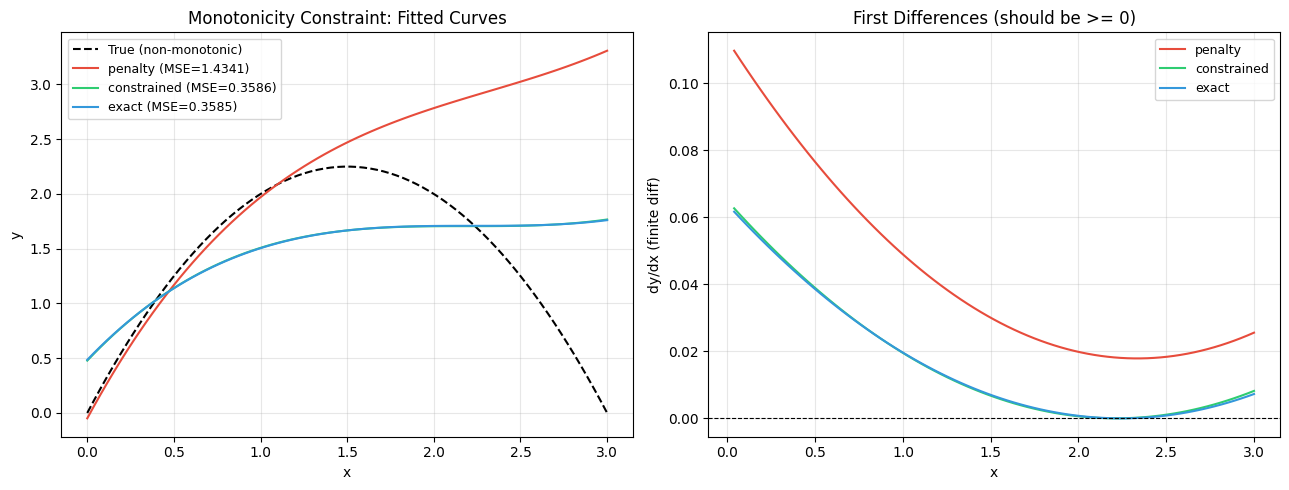

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Left: fitted curves
ax = axes[0]
ax.plot(X_mono, y_mono, "k--", label="True (non-monotonic)", linewidth=1.5)
colors = {"penalty": "#e74c3c", "constrained": "#2ecc71", "exact": "#3498db"}
for level, r in results_mono.items():
    ax.plot(X_mono, r["y_pred"], color=colors[level], label=f"{level} (MSE={r['mse']:.4f})")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Monotonicity Constraint: Fitted Curves")
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Right: first differences (should all be >= 0)
ax = axes[1]
x_diff = X_mono[1:, 0]
for level, r in results_mono.items():
    diffs = np.diff(r["y_pred"])
    ax.plot(x_diff, diffs, color=colors[level], label=level)
ax.axhline(0, color="k", linestyle="--", linewidth=0.8)
ax.set_xlabel("x")
ax.set_ylabel("dy/dx (finite diff)")
ax.set_title("First Differences (should be >= 0)")
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## 2. Convexity Constraint

True model: $y = -x^2$ (concave). We fit with a **convexity** constraint, so the
solver must find the best convex approximation.

In [5]:
X_cvx = np.linspace(-2, 2, 80).reshape(-1, 1)
y_cvx = -X_cvx[:, 0] ** 2 + 0.1 * np.random.randn(80)

library_cvx = (
    BasisLibrary(n_features=1, feature_names=["x"])
    .add_constant()
    .add_linear()
    .add_polynomials(max_degree=3)
)
Phi_cvx = library_cvx.evaluate(jnp.array(X_cvx))
sel_cvx = jnp.arange(len(library_cvx.names))

constraints_cvx = Constraints().add_convex("x", hard=True)

results_cvx = {}
for level in LEVELS:
    coeffs, mse, elapsed = fit_and_time(
        Phi_cvx, jnp.array(y_cvx), jnp.array(X_cvx),
        constraints_cvx, library_cvx.names, ["x"],
        library_cvx, sel_cvx, level,
    )
    y_pred = np.array(Phi_cvx @ coeffs)
    n_viol, worst = convexity_violations(y_pred)
    results_cvx[level] = {
        "coeffs": coeffs, "mse": mse, "time": elapsed,
        "y_pred": y_pred, "n_violations": n_viol, "worst_violation": worst,
    }

print(f"{'Level':<14s} {'MSE':>10s} {'Violations':>11s} {'Worst 2nd diff':>15s} {'Time (ms)':>10s}")
print("-" * 65)
for level, r in results_cvx.items():
    print(
        f"{level:<14s} {r['mse']:10.6f} {r['n_violations']:11d}"
        f" {r['worst_violation']:15.2e} {r['time']*1000:10.1f}"
    )

Level                 MSE  Violations  Worst 2nd diff  Time (ms)
-----------------------------------------------------------------
penalty          6.796982           0        5.44e-05      245.4
constrained      1.473060           2       -1.19e-07       78.1
exact            1.472959          38       -1.19e-07        3.7


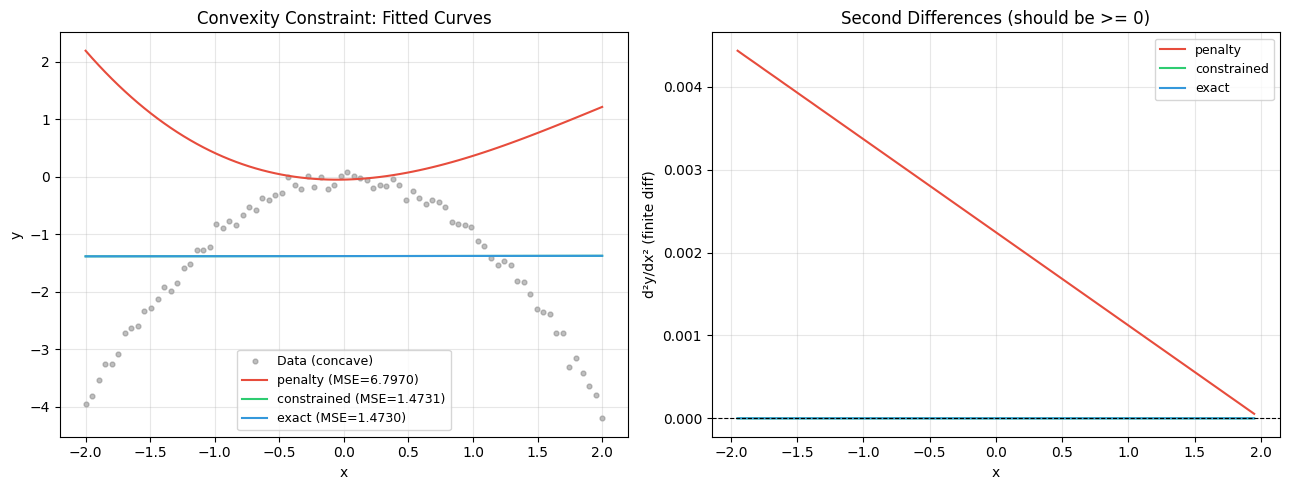

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

ax = axes[0]
ax.scatter(X_cvx, y_cvx, s=12, alpha=0.5, color="gray", label="Data (concave)")
for level, r in results_cvx.items():
    ax.plot(X_cvx, r["y_pred"], color=colors[level], label=f"{level} (MSE={r['mse']:.4f})")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Convexity Constraint: Fitted Curves")
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

ax = axes[1]
x_sd = X_cvx[1:-1, 0]
for level, r in results_cvx.items():
    sd = np.diff(r["y_pred"], n=2)
    ax.plot(x_sd, sd, color=colors[level], label=level)
ax.axhline(0, color="k", linestyle="--", linewidth=0.8)
ax.set_xlabel("x")
ax.set_ylabel("d²y/dx² (finite diff)")
ax.set_title("Second Differences (should be >= 0)")
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## 3. Output Bounds Constraint

True model: $y = 2x + 1$ over $x \in [0, 5]$, giving $y \in [1, 11]$.
We impose a hard upper bound $y \le 8$, which the true model violates for $x > 3.5$.
The solver must find the best fit that respects the bound at the training points.

In [7]:
X_bnd = np.linspace(0, 5, 80).reshape(-1, 1)
y_bnd = 2 * X_bnd[:, 0] + 1 + 0.2 * np.random.randn(80)
UPPER = 8.0

library_bnd = (
    BasisLibrary(n_features=1, feature_names=["x"])
    .add_constant()
    .add_linear()
    .add_polynomials(max_degree=2)
)
Phi_bnd = library_bnd.evaluate(jnp.array(X_bnd))
sel_bnd = jnp.arange(len(library_bnd.names))

constraints_bnd = Constraints().add_bounds("y", upper=UPPER, hard=True)

results_bnd = {}
for level in LEVELS:
    coeffs, mse, elapsed = fit_and_time(
        Phi_bnd, jnp.array(y_bnd), jnp.array(X_bnd),
        constraints_bnd, library_bnd.names, ["x"],
        library_bnd, sel_bnd, level,
    )
    y_pred = np.array(Phi_bnd @ coeffs)
    n_viol, worst = bound_violations(y_pred, UPPER)
    results_bnd[level] = {
        "coeffs": coeffs, "mse": mse, "time": elapsed,
        "y_pred": y_pred, "n_violations": n_viol, "worst_violation": worst,
    }

print(f"{'Level':<14s} {'MSE':>10s} {'Violations':>11s} {'Max excess':>11s} {'Time (ms)':>10s}")
print("-" * 60)
for level, r in results_bnd.items():
    print(
        f"{level:<14s} {r['mse']:10.6f} {r['n_violations']:11d}"
        f" {r['worst_violation']:11.2e} {r['time']*1000:10.1f}"
    )

Level                 MSE  Violations  Max excess  Time (ms)
------------------------------------------------------------
penalty          1.959617           0   -6.32e-02      290.1
constrained      1.135383           0   -3.29e-05       67.0
exact            1.135312           1    9.54e-07        2.5


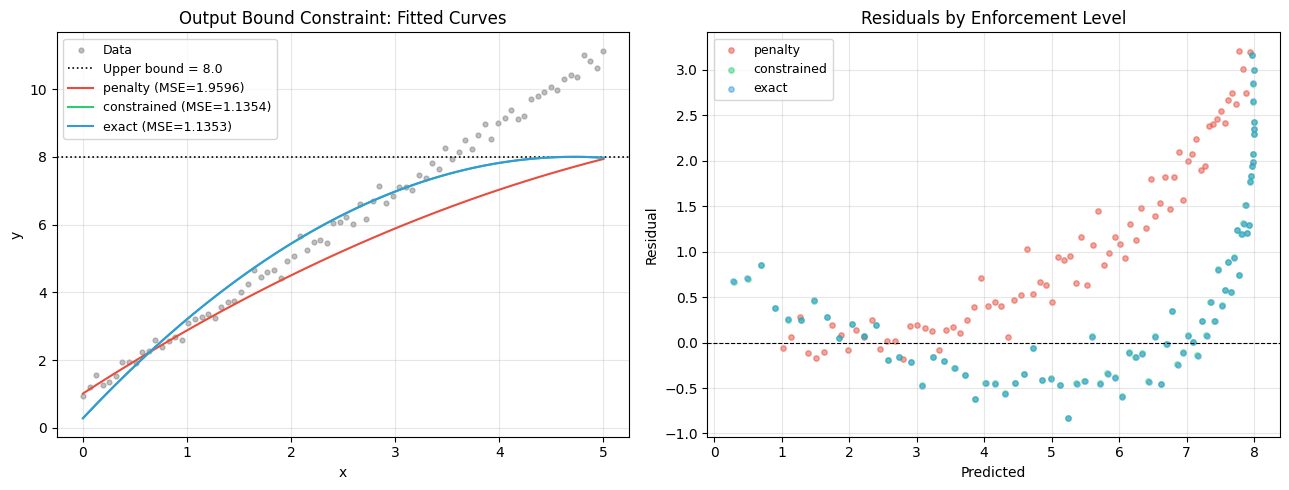

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

ax = axes[0]
ax.scatter(X_bnd, y_bnd, s=12, alpha=0.5, color="gray", label="Data")
ax.axhline(UPPER, color="k", linestyle=":", linewidth=1.2, label=f"Upper bound = {UPPER}")
for level, r in results_bnd.items():
    ax.plot(X_bnd, r["y_pred"], color=colors[level], label=f"{level} (MSE={r['mse']:.4f})")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Output Bound Constraint: Fitted Curves")
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Right: residuals
ax = axes[1]
for level, r in results_bnd.items():
    resid = y_bnd - r["y_pred"]
    ax.scatter(r["y_pred"], resid, s=15, alpha=0.5, color=colors[level], label=level)
ax.axhline(0, color="k", linestyle="--", linewidth=0.8)
ax.set_xlabel("Predicted")
ax.set_ylabel("Residual")
ax.set_title("Residuals by Enforcement Level")
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## 4. Summary of Enforcement Levels

Collect all results into a single comparison table.

In [9]:
print(f"{'Problem':<16s} {'Level':<14s} {'MSE':>10s} {'Violations':>11s} {'Time (ms)':>10s}")
print("=" * 65)
for label, res in [("Monotonicity", results_mono), ("Convexity", results_cvx), ("Upper Bound", results_bnd)]:
    for level, r in res.items():
        print(
            f"{label:<16s} {level:<14s} {r['mse']:10.6f}"
            f" {r['n_violations']:11d} {r['time']*1000:10.1f}"
        )
    print("-" * 65)

Problem          Level                 MSE  Violations  Time (ms)
Monotonicity     penalty          1.434053           0      188.7
Monotonicity     constrained      0.358622           0      116.7
Monotonicity     exact            0.358550           1        3.6
-----------------------------------------------------------------
Convexity        penalty          6.796982           0      245.4
Convexity        constrained      1.473060           2       78.1
Convexity        exact            1.472959          38        3.7
-----------------------------------------------------------------
Upper Bound      penalty          1.959617           0      290.1
Upper Bound      constrained      1.135383           0       67.0
Upper Bound      exact            1.135312           1        2.5
-----------------------------------------------------------------


**Key observations:**

- **`penalty`**: Fastest, but may have small residual violations.
- **`constrained`**: Slightly slower, violations driven to solver tolerance.
- **`exact`** (if available): Violations at machine precision, but requires `cvxpy`.

---
## 5. Using `SymbolicRegressor` with Enforcement Levels

The `constraint_enforcement` parameter on `SymbolicRegressor` passes through
to the internal fitting routine. Here we demonstrate the full pipeline.

In [10]:
# Reaction rate: r = k * C^0.5, must be non-negative and increasing in C
np.random.seed(123)
C = np.random.uniform(0.1, 3.0, 100).reshape(-1, 1)
rate = 2.0 * C[:, 0] ** 0.5 + 0.05 * np.random.randn(100)

library_rate = (
    BasisLibrary(n_features=1, feature_names=["C"])
    .add_constant()
    .add_linear()
    .add_polynomials(max_degree=2)
    .add_transcendental(["sqrt", "log"])
)

constraints_rate = (
    Constraints()
    .add_bounds("y", lower=0, hard=True)
    .add_monotonic("C", direction="increasing", hard=True)
)

for level in LEVELS:
    t0 = time.perf_counter()
    model = SymbolicRegressor(
        basis_library=library_rate,
        max_terms=3,
        constraints=constraints_rate,
        constraint_enforcement=level,
    )
    model.fit(C, rate)
    elapsed = time.perf_counter() - t0

    y_pred = np.array(model.predict(C))
    n_neg = int(np.sum(y_pred < -1e-10))
    C_sorted = np.sort(C[:, 0])
    y_sorted = np.array(model.predict(C_sorted.reshape(-1, 1)))
    n_mono, _ = monotonic_violations(y_sorted)

    print(f"[{level:<12s}]  expr = {model.expression_}")
    print(f"{'':14s}  R² = {model.score(C, rate):.6f}  "
          f"neg preds = {n_neg}  mono violations = {n_mono}  "
          f"time = {elapsed*1000:.0f} ms")
    print()

[penalty     ]  expr = y = 2.001*sqrt(C)
                R² = 0.993762  neg preds = 0  mono violations = 0  time = 1374 ms

[constrained ]  expr = y = 2.002*sqrt(C)
                R² = 0.993758  neg preds = 0  mono violations = 0  time = 61 ms

[exact       ]  expr = y = 2.001*sqrt(C)
                R² = 0.993762  neg preds = 0  mono violations = 0  time = 12 ms



---
## 6. CSTR Reactor: Mass-Balance Constraint $x_A + x_B = 1$

### Problem setup

Consider a CSTR with irreversible reaction $A \to B$.  The mole fractions
$x_A$ and $x_B$ are measured as functions of temperature $T$ and space time
$\tau$.  By mass balance, $x_A + x_B = 1$ exactly, but each measurement is
independently noisy so the measured values do not sum to 1.

We fit **separate** symbolic regression models for $x_A(T, \tau)$ and
$x_B(T, \tau)$, then use a **linear constraint on the combined coefficient
vector** to enforce the mass balance across both models simultaneously.

### True model

$$
x_A = \frac{1}{1 + k(T)\,\tau}, \qquad x_B = 1 - x_A
$$

where $k(T) = 0.5\,e^{0.05\,(T - 300)}$ is an Arrhenius-like rate constant.

In [11]:
# Generate CSTR data
np.random.seed(42)
n_obs = 120
T = np.random.uniform(280, 350, n_obs)   # temperature [K]
tau = np.random.uniform(0.5, 5.0, n_obs)  # space time [min]

k_true = 0.5 * np.exp(0.05 * (T - 300))
xA_true = 1.0 / (1.0 + k_true * tau)
xB_true = 1.0 - xA_true

# Add independent measurement noise
sigma_noise = 0.02
xA_obs = xA_true + sigma_noise * np.random.randn(n_obs)
xB_obs = xB_true + sigma_noise * np.random.randn(n_obs)

print(f"Mass-balance error in noisy data: "
      f"mean|xA+xB-1| = {np.mean(np.abs(xA_obs + xB_obs - 1)):.4f}")
print(f"Max |xA+xB-1| = {np.max(np.abs(xA_obs + xB_obs - 1)):.4f}")

Mass-balance error in noisy data: mean|xA+xB-1| = 0.0222
Max |xA+xB-1| = 0.1073


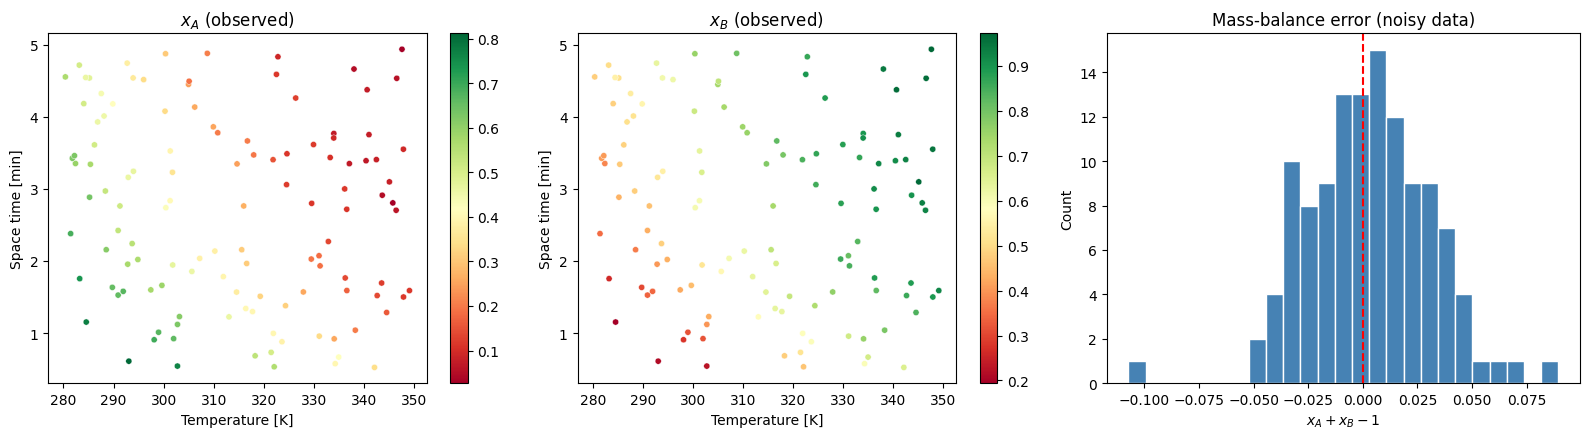

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4.5))

sc = axes[0].scatter(T, tau, c=xA_obs, cmap="RdYlGn", s=20, edgecolors="white", linewidth=0.3)
axes[0].set_xlabel("Temperature [K]")
axes[0].set_ylabel("Space time [min]")
axes[0].set_title("$x_A$ (observed)")
plt.colorbar(sc, ax=axes[0])

sc = axes[1].scatter(T, tau, c=xB_obs, cmap="RdYlGn", s=20, edgecolors="white", linewidth=0.3)
axes[1].set_xlabel("Temperature [K]")
axes[1].set_ylabel("Space time [min]")
axes[1].set_title("$x_B$ (observed)")
plt.colorbar(sc, ax=axes[1])

axes[2].hist(xA_obs + xB_obs - 1, bins=25, color="steelblue", edgecolor="white")
axes[2].axvline(0, color="r", linestyle="--")
axes[2].set_xlabel("$x_A + x_B - 1$")
axes[2].set_ylabel("Count")
axes[2].set_title("Mass-balance error (noisy data)")

plt.tight_layout()
plt.show()

### Strategy: joint basis matrix with coefficient-level constraints

To enforce $x_A + x_B = 1$ as a linear constraint on coefficients, we
construct a **joint** design matrix by stacking the $x_A$ and $x_B$ basis
matrices block-diagonally:

$$
\Phi_{\text{joint}} = \begin{pmatrix} \Phi & 0 \\ 0 & \Phi \end{pmatrix}, \qquad
\mathbf{c} = \begin{pmatrix} \mathbf{c}_A \\ \mathbf{c}_B \end{pmatrix}, \qquad
\mathbf{y} = \begin{pmatrix} x_A \\ x_B \end{pmatrix}
$$

The mass-balance constraint $\hat{x}_A + \hat{x}_B = 1$ for all inputs requires
$\Phi\,(\mathbf{c}_A + \mathbf{c}_B) = \mathbf{1}$. Since the first basis function
is the constant "1", this is equivalent to the **coefficient-level** constraints:

- $c_A^{(0)} + c_B^{(0)} = 1$ (constant terms sum to 1)
- $c_A^{(j)} + c_B^{(j)} = 0$ for $j = 1, \ldots, p-1$ (other terms cancel)

This gives just $p$ equality constraints on $2p$ coefficients — much more
efficient than constraining at each observation.

In [13]:
# Build shared basis library (same features for xA and xB)
X_cstr = np.column_stack([T, tau])

library_cstr = (
    BasisLibrary(n_features=2, feature_names=["T", "tau"])
    .add_constant()
    .add_linear()
    .add_polynomials(max_degree=2)
    .add_interactions()
)

Phi_single = np.array(library_cstr.evaluate(jnp.array(X_cstr)))
n_basis = Phi_single.shape[1]
basis_names_single = library_cstr.names

print(f"Basis functions ({n_basis}): {basis_names_single}")

# Build block-diagonal joint design matrix
Phi_joint = np.zeros((2 * n_obs, 2 * n_basis))
Phi_joint[:n_obs, :n_basis] = Phi_single       # xA block
Phi_joint[n_obs:, n_basis:] = Phi_single        # xB block

y_joint = np.concatenate([xA_obs, xB_obs])

# Joint basis names
basis_names_joint = (
    [f"A:{n}" for n in basis_names_single]
    + [f"B:{n}" for n in basis_names_single]
)

print(f"Joint system: {Phi_joint.shape[0]} obs x {Phi_joint.shape[1]} coefficients")

Basis functions (6): ['1', 'T', 'tau', 'T^2', 'tau^2', 'T*tau']
Joint system: 240 obs x 12 coefficients


In [14]:
# Coefficient-level mass-balance constraints:
#   c_A[0] + c_B[0] = 1      (constant terms sum to 1)
#   c_A[j] + c_B[j] = 0      (all other terms cancel)
#
# In the joint coefficient vector c = [c_A; c_B] of length 2*n_basis,
# each row of A selects a pair: A[j, j] = 1, A[j, n_basis+j] = 1.
# Encode equality as two inequalities: A @ c <= b AND -A @ c <= -b.

A_eq = np.zeros((n_basis, 2 * n_basis))
for j in range(n_basis):
    A_eq[j, j] = 1.0            # c_A[j]
    A_eq[j, n_basis + j] = 1.0  # c_B[j]

b_eq = np.zeros(n_basis)
b_eq[0] = 1.0  # constant term sums to 1

# Stack as two-sided inequality for add_linear_constraint (A @ c <= b)
A_ineq = np.vstack([A_eq, -A_eq])
b_ineq = np.concatenate([b_eq, -b_eq])

print(f"Coefficient-level constraint: {A_eq.shape[0]} equalities on {2*n_basis} coefficients")
print(f"Encoded as {A_ineq.shape[0]} inequality rows")

Coefficient-level constraint: 6 equalities on 12 coefficients
Encoded as 12 inequality rows


### Fit without constraint (baseline)

In [15]:
# Unconstrained OLS baseline
coeffs_ols, _, _, _ = np.linalg.lstsq(Phi_joint, y_joint, rcond=None)
y_pred_ols = Phi_joint @ coeffs_ols
xA_pred_ols = y_pred_ols[:n_obs]
xB_pred_ols = y_pred_ols[n_obs:]
mse_ols = float(np.mean((y_joint - y_pred_ols) ** 2))
mb_error_ols = np.abs(xA_pred_ols + xB_pred_ols - 1)

print(f"Unconstrained OLS: MSE = {mse_ols:.6f}")
print(f"  mean|xA+xB-1| = {np.mean(mb_error_ols):.6f}")
print(f"  max |xA+xB-1| = {np.max(mb_error_ols):.6f}")

Unconstrained OLS: MSE = 0.000779
  mean|xA+xB-1| = 0.004844
  max |xA+xB-1| = 0.019694


### Fit with mass-balance constraint at each enforcement level

In [16]:
results_cstr = {}

for level in LEVELS:
    constraints_cstr = Constraints().add_linear_constraint(
        A_ineq, b_ineq, hard=True
    )

    t0 = time.perf_counter()
    coeffs, mse = fit_constrained_ols(
        Phi=jnp.array(Phi_joint),
        y=jnp.array(y_joint),
        constraints=constraints_cstr,
        basis_names=basis_names_joint,
        feature_names=["T", "tau"],
        X=jnp.array(X_cstr),
        enforcement=level,
        max_iter=200,
    )
    elapsed = time.perf_counter() - t0

    y_pred = np.array(jnp.array(Phi_joint) @ coeffs)
    xA_pred = y_pred[:n_obs]
    xB_pred = y_pred[n_obs:]
    mb_error = np.abs(xA_pred + xB_pred - 1)

    results_cstr[level] = {
        "coeffs": coeffs, "mse": mse, "time": elapsed,
        "xA_pred": xA_pred, "xB_pred": xB_pred,
        "mb_mean": float(np.mean(mb_error)),
        "mb_max": float(np.max(mb_error)),
    }

print(f"{'Level':<14s} {'MSE':>10s} {'mean|err|':>10s} {'max|err|':>10s} {'Time (ms)':>10s}")
print("=" * 58)
print(f"{'unconstrained':<14s} {mse_ols:10.6f} {np.mean(mb_error_ols):10.6f}"
      f" {np.max(mb_error_ols):10.6f} {'--':>10s}")
for level, r in results_cstr.items():
    print(
        f"{level:<14s} {r['mse']:10.6f} {r['mb_mean']:10.2e}"
        f" {r['mb_max']:10.2e} {r['time']*1000:10.1f}"
    )

Level                 MSE  mean|err|   max|err|  Time (ms)
unconstrained    0.000779   0.004844   0.019694         --
penalty          0.003603   3.19e-03   4.00e-03      773.4
constrained      0.013170   2.63e-08   1.19e-07      707.3
exact            0.000789   0.00e+00   0.00e+00        4.0


**Note on penalty enforcement for the mass balance:** The `"penalty"` level achieves
only approximate constraint satisfaction (max |xA+xB-1| ~ 4e-3) while incurring a
significant MSE increase (0.0008 to 0.0036). This reflects the fundamental trade-off
in penalty methods: the solver balances data fidelity against the penalty for constraint
violation, and the default penalty weight may not be optimal for every problem.
Increasing `penalty_weight` would reduce the mass-balance error but further increase MSE.

By contrast, `"constrained"` (trust-constr) satisfies the mass balance to solver
tolerance (~1e-7) but at even greater MSE cost (0.013), while `"exact"` (cvxpy QP)
achieves exact satisfaction with minimal MSE increase (0.0008). For problems where
exact conservation-law enforcement is required, use `enforcement="exact"` or the
hard-constraint null-space approach demonstrated in the Gibbs-Duhem activity notebook.

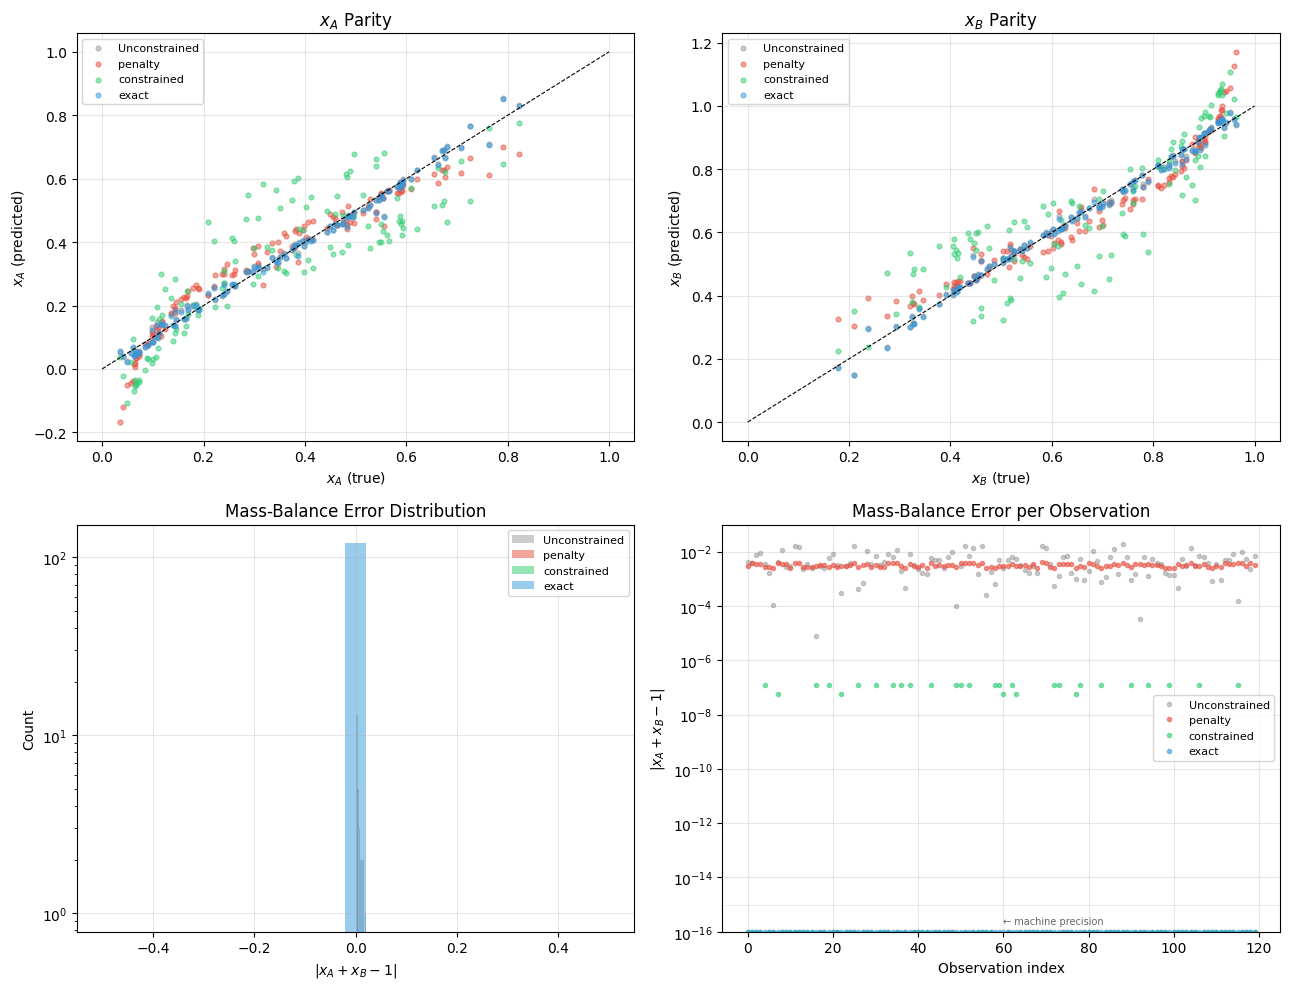

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(13, 10))

# Top-left: xA parity
ax = axes[0, 0]
ax.scatter(xA_true, xA_pred_ols, s=12, alpha=0.4, color="gray", label="Unconstrained")
for level, r in results_cstr.items():
    ax.scatter(xA_true, r["xA_pred"], s=12, alpha=0.5, color=colors[level], label=level)
lims = [0, 1]
ax.plot(lims, lims, "k--", linewidth=0.8)
ax.set_xlabel("$x_A$ (true)")
ax.set_ylabel("$x_A$ (predicted)")
ax.set_title("$x_A$ Parity")
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# Top-right: xB parity
ax = axes[0, 1]
ax.scatter(xB_true, xB_pred_ols, s=12, alpha=0.4, color="gray", label="Unconstrained")
for level, r in results_cstr.items():
    ax.scatter(xB_true, r["xB_pred"], s=12, alpha=0.5, color=colors[level], label=level)
ax.plot(lims, lims, "k--", linewidth=0.8)
ax.set_xlabel("$x_B$ (true)")
ax.set_ylabel("$x_B$ (predicted)")
ax.set_title("$x_B$ Parity")
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# Bottom-left: mass-balance error histogram
ax = axes[1, 0]
ax.hist(mb_error_ols, bins=25, alpha=0.4, color="gray", label="Unconstrained")
for level, r in results_cstr.items():
    mb_err = np.abs(r["xA_pred"] + r["xB_pred"] - 1)
    ax.hist(mb_err, bins=25, alpha=0.5, color=colors[level], label=level)
ax.set_xlabel("$|x_A + x_B - 1|$")
ax.set_ylabel("Count")
ax.set_title("Mass-Balance Error Distribution")
ax.legend(fontsize=8)
ax.set_yscale("log")
ax.grid(True, alpha=0.3)

# Bottom-right: mass-balance error vs observation index with floor for log scale
ax = axes[1, 1]
# Add small offset to avoid log(0) - values at machine precision will show at bottom
floor = 1e-16  # Floor for plotting on log scale
ax.plot(np.maximum(mb_error_ols, floor), "o", markersize=3, alpha=0.4, color="gray", label="Unconstrained")
for level, r in results_cstr.items():
    mb_err = np.abs(r["xA_pred"] + r["xB_pred"] - 1)
    # Plot with floor to make exact zeros visible
    ax.plot(np.maximum(mb_err, floor), "o", markersize=3, alpha=0.6, color=colors[level], label=level)
ax.set_xlabel("Observation index")
ax.set_ylabel("$|x_A + x_B - 1|$")
ax.set_title("Mass-Balance Error per Observation")
ax.legend(fontsize=8)
ax.set_yscale("log")
ax.set_ylim(bottom=floor, top=1e-1)  # Set explicit y-axis limits
ax.axhline(1e-15, color="k", linestyle=":", linewidth=0.5, alpha=0.3)
ax.text(60, 2e-16, "← machine precision", fontsize=7, alpha=0.6)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Fitted coefficients

In [18]:
# Show coefficients for one representative level
best_level = "constrained" if "constrained" in results_cstr else "penalty"
coeffs_best = np.array(results_cstr[best_level]["coeffs"])

print(f"Fitted coefficients ({best_level} enforcement):")
print(f"{'Basis':>20s}  {'Coeff (xA)':>12s}  {'Coeff (xB)':>12s}  {'Sum':>10s}")
print("-" * 60)
for i, name in enumerate(basis_names_single):
    cA = coeffs_best[i]
    cB = coeffs_best[n_basis + i]
    print(f"{name:>20s}  {cA:12.6f}  {cB:12.6f}  {cA+cB:10.6f}")

print()
print("Note: for the constant term, cA + cB should equal 1.")
print("For all other terms, cA + cB should equal 0.")
print("(This is how Phi @ (cA + cB) = 1 works out when the constant column is all-ones.)")

Fitted coefficients (constrained enforcement):
               Basis    Coeff (xA)    Coeff (xB)         Sum
------------------------------------------------------------
                   1      0.500527      0.499473    1.000000
                   T      0.006456     -0.006456    0.000000
                 tau     -0.003109      0.003109    0.000000
                 T^2     -0.000016      0.000016    0.000000
               tau^2      0.072677     -0.072677    0.000000
               T*tau     -0.001470      0.001470    0.000000

Note: for the constant term, cA + cB should equal 1.
For all other terms, cA + cB should equal 0.
(This is how Phi @ (cA + cB) = 1 works out when the constant column is all-ones.)


### Verify constraint satisfaction

In [19]:
print("Mass-balance constraint satisfaction:")
print(f"{'Level':<14s} {'mean|xA+xB-1|':>15s} {'max|xA+xB-1|':>15s} {'Satisfied?':>12s}")
print("-" * 60)
print(f"{'unconstrained':<14s} {np.mean(mb_error_ols):15.2e} {np.max(mb_error_ols):15.2e} {'No':>12s}")
for level, r in results_cstr.items():
    sat = "Yes" if r["mb_max"] < 1e-4 else "Approx"
    print(f"{level:<14s} {r['mb_mean']:15.2e} {r['mb_max']:15.2e} {sat:>12s}")

Mass-balance constraint satisfaction:
Level            mean|xA+xB-1|    max|xA+xB-1|   Satisfied?
------------------------------------------------------------
unconstrained         4.84e-03        1.97e-02           No
penalty               3.19e-03        4.00e-03       Approx
constrained           2.63e-08        1.19e-07          Yes
exact                 0.00e+00        0.00e+00          Yes


---
## 7. Soft vs Hard Constraints

The `hard` flag on each constraint interacts with the enforcement level:

- **`hard=False`** constraints are always treated as **soft penalties**, regardless
  of the enforcement level.
- **`hard=True`** constraints get the full enforcement mechanism for the chosen level.

Here we demonstrate with the monotonicity example.

In [20]:
# Compare hard vs soft monotonicity at each level
print(f"{'hard':>5s} {'Level':<14s} {'MSE':>10s} {'Violations':>11s} {'Worst diff':>12s}")
print("=" * 56)

for hard_flag in [True, False]:
    constraints_hs = Constraints().add_monotonic(
        "x", direction="increasing", hard=hard_flag, weight=10.0
    )
    for level in LEVELS:
        coeffs, mse = fit_constrained_ols(
            Phi=Phi_mono, y=jnp.array(y_mono), constraints=constraints_hs,
            basis_names=library_mono.names, feature_names=["x"],
            X=jnp.array(X_mono), basis_library=library_mono,
            selected_indices=sel_mono, enforcement=level,
            penalty_weight=10.0,
        )
        y_pred = np.array(Phi_mono @ coeffs)
        n_viol, worst = monotonic_violations(y_pred)
        print(
            f"{str(hard_flag):>5s} {level:<14s} {mse:10.6f}"
            f" {n_viol:11d} {worst:12.2e}"
        )
    print("-" * 56)

 hard Level                 MSE  Violations   Worst diff


 True penalty          1.434053           0     1.79e-02


 True constrained      0.358622           0     5.25e-06
 True exact            0.358550           1    -2.15e-06
--------------------------------------------------------


False penalty          0.397386           3    -6.01e-05


False constrained      0.398521           3    -7.72e-05
False exact            0.000000          39    -1.12e-01
--------------------------------------------------------


With `hard=True`, the `constrained` and `exact` levels enforce the monotonicity
constraint tightly (near solver tolerance), while `penalty` provides approximate
satisfaction through a penalty term.

With `hard=False`, the `penalty` and `constrained` levels both treat the constraint
as a soft penalty, producing similar results (a few small violations). However, the
`"exact"` (cvxpy QP) solver **ignores soft constraints entirely** -- the QP formulation
only supports hard inequality constraints and has no penalty mechanism. As a result,
`hard=False` with `enforcement="exact"` produces an unconstrained OLS solution
(MSE near 0, but many constraint violations). This is correct behavior: if you want
soft constraint guidance, use `"penalty"` or `"constrained"` enforcement.

---
## Summary

| Scenario | Recommended Level |
|----------|------------------|
| Quick exploration, soft guidance | `"penalty"` |
| Safety-critical bounds, physical laws | `"constrained"` |
| Publication-quality, tightest enforcement | `"exact"` (requires `cvxpy`) |

**Key points:**

1. `"penalty"` is the fastest but may leave small residual violations.
2. `"constrained"` (trust-constr) provides solver-level guarantees with no extra dependencies.
3. `"exact"` (cvxpy QP) gives solver-precision enforcement but requires `cvxpy` and does not support
   nonlinear (CUSTOM) hard constraints.
4. Soft constraints (`hard=False`) are handled as penalties by `"penalty"` and `"constrained"`,
   but are **ignored by `"exact"`** (the QP solver has no penalty mechanism, so it falls back
   to unconstrained OLS). Use `"penalty"` or `"constrained"` for soft constraints.
5. The CSTR mass-balance example shows how linear equality constraints can enforce
   physical conservation laws across multiple correlated outputs.